<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 1. Importing Necessary Library

</a>
    
</div>

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [4]:
# df_sample = pd.read_csv("sample_submission.csv")
# df_sample

<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 2. Exploring DataSet

</a>
    
</div>

In [5]:
df_train = pd.read_csv("train.csv")
df_train.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

In [7]:
df_train.Buy.value_counts()

0    8447
1    1552
Name: Buy, dtype: int64

### <font color='#E8800A'>Features  

-  Access_ID - Unique identification of the user access to the website 
- Date - Website visit date
- AccountMng_Pages - Number of pages visited by the user about account management
- AccountMng_Duration - Total amount of time (seconds) spent by the user on account management related pages
- FAQ_Pages - Number of pages visited by the user about frequently asked questions, shipping information and company related pages
- FAQ_Duration - Total amount of time (seconds) spent by the user on FAQ pages
- Product_Pages - Number of pages visited by the user about products and services offered by the company
- Product_Duration - Total amount in time (seconds) spent by the user on products and services related pages
- GoogleAnalytics_BounceRate - Average bounce rate value of the pages visited by the user, provided by google analytics
- GoogleAnalytics_ExitRate - Average exit rate value of the pages visited by the user, provided by google analytics
- GoogleAnalytics_PageValue - Average page value of the pages visited by the user, provided by google analytics
- OS - Operating System of the user
- Browser - Browser used to access the webpage
- Country - The country of the user
- Type_of_Traffic - Traffic Source by which the user has accessed the website (e.g., email, banner, direct)
- Type_of_Visitor - User type as "New access", "Returner" or "Other"
- Buy - Class label indicating if the user finalized their actions in the website with a transaction

In [8]:
df_train_original = df_train.copy()

In [9]:
#droping product_Duration column
#df_train = df_train.drop(columns = ["Product_Duration"])

In [10]:
# No data from January and April
print(len(df_train[df_train.Date.str.contains("Jan")]), 
      len(df_train[df_train.Date.str.contains("Apr")]))

0 0


In [11]:
#df_train.info()

In [12]:
# Note: bounce rate is always less then exit rate, all bounce are exits but vice verca is not true.
# if we are considering the bounce rate of particular webpage(let's say A), then the total number of session for that calculation has to be included only those sessions which has been started with A. 
# Exit rate of zero is impossible unless you visit the website

In [13]:
df_train.Buy.value_counts().sum().astype(int)

9999

In [14]:
# Binary Target Variable
df_train.Buy.value_counts()

0    8447
1    1552
Name: Buy, dtype: int64

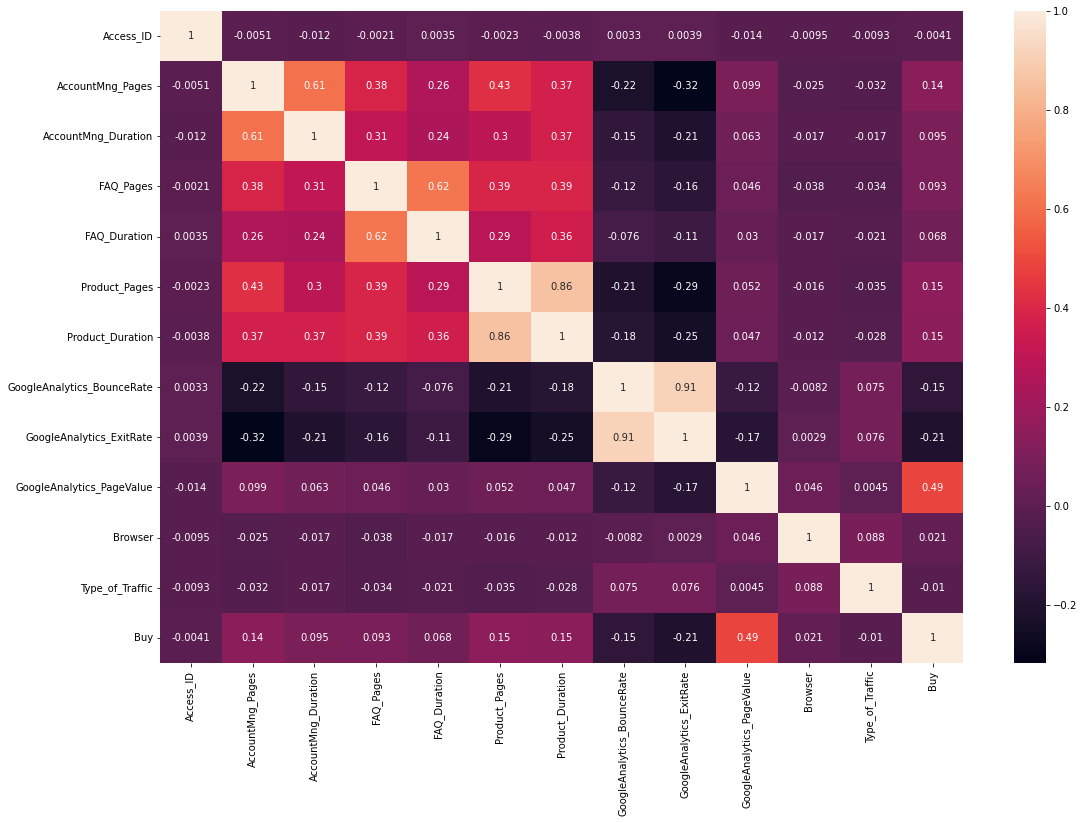

In [15]:
# building a correlaton heatmap for visual representation of correlation between each numerical variables
# Here we are using pearson correlation coefficient
plt.figure(figsize = (18,12))
sns.heatmap(df_train.corr(), annot = True)
plt.show()

In [16]:
df_train.Date.value_counts()

25-May-20    120
5-May-20     111
7-May-20     110
14-May-20    110
8-May-20     109
            ... 
28-Jun-20      3
16-Feb-20      2
29-Feb-20      2
17-Feb-20      2
15-Feb-20      2
Name: Date, Length: 305, dtype: int64

In [17]:
# converting column "Date" from object to Datetime
df_train.Date = df_train.Date.apply(pd.to_datetime)

In [18]:
df_train.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,2020-12-22,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,2020-11-24,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [19]:
#Splitting column Date into Month, Year, and Day
df_train["Month"] = pd.DatetimeIndex(df_train["Date"]).month
df_train["Year"] = pd.DatetimeIndex(df_train["Date"]).year
df_train["Day"] = pd.DatetimeIndex(df_train["Date"]).day

In [20]:
# dropping the original column Date from df_train
df_train = df_train.drop(columns = ["Date"])

In [21]:
# since the dataset has same year for every observations, so it is dropped too.
df_train = df_train.drop(columns = ["Year"])

In [22]:
# droping Access_ID 
df_train = df_train.drop(columns = ["Access_ID"])

In [23]:
df_train

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day
0,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0,3,21
1,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0,5,20
2,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0,12,4
3,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1,12,22
4,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1,11,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0,5,8
9995,6,175.1,0,0.0,3,27.6000,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0,7,17
9996,0,0.0,0,0.0,27,644.0000,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0,3,23
9997,0,0.0,0,0.0,53,715.5000,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0,5,16


##### First step on Feature Grouping

In [24]:
# combining features with duration and pages by creating a single feature called duration per page
df_train["Acc_Mng_D_perpage"] = df_train["AccountMng_Duration"] / df_train["AccountMng_Pages"]

# Small note
#zero value for Acc_Mng_D_perpage indicates two distinct reason
# 1. The user accessed to the Account-Management page but did not stay there
# 2. The user did not accessed to the page and obviously it has nothing to do with AccoutMng_Duration
# anyway, value zero for AccountMng_Pages always has its corresponding value zero for AccountMng_Duration

In [25]:
# Similarly we can obtain relevency from four more columns((FAQ_Pages abd FAQ_Duration), 
# and (Product_Pages and product_Duration)))
df_train["FAQ_Duration_perpage"] = df_train["FAQ_Duration"] / df_train["FAQ_Pages"]
df_train["Product_Duration_perpage"] = df_train["Product_Duration"] / df_train["Product_Pages"]
df_train = df_train.drop(columns = ["AccountMng_Pages","AccountMng_Duration","FAQ_Pages","FAQ_Duration","Product_Pages","Product_Duration"])
df_train = df_train.replace(np.nan, 0)

### Highly correlated feature removal
###### Since Google_Analytics_Exit_Rate and Google_Analytics_Bounce_Rate has high correlation let us remove on of the feature


In [26]:
df_train = df_train.drop(columns = ['GoogleAnalytics_BounceRate'])

In [27]:
df_train

,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage
0,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0,3,21,0.000000,0.00,21.333333
1,0.0449,0.0000,Windows,2,France,6,Returner,0,5,20,0.000000,0.00,29.760870
2,0.0583,0.0000,Windows,4,Italy,1,Returner,0,12,4,0.000000,0.00,11.875000
3,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1,12,22,0.000000,0.00,67.638889
4,0.0093,12.5033,Windows,2,Spain,3,Returner,1,11,24,0.000000,193.00,44.720547
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0,5,8,53.000000,27.75,47.831522
9995,0.0111,0.0000,Windows,10,Spain,5,New_Access,0,7,17,29.183333,0.00,9.200000
9996,0.0519,0.0000,MacOSX,2,France,3,Returner,0,3,23,0.000000,0.00,23.851852
9997,0.0363,0.0000,Windows,2,Italy,3,Returner,0,5,16,0.000000,0.00,13.500000


In [28]:
#Define metric, non-metric features and target variable seperately
non_metric_features = ['OS',"Country","Type_of_Visitor"]
metric_features = df_train.columns.drop(non_metric_features).to_list()
metric_features.remove('Buy')
target_variable = ['Buy']

In [29]:
all_features = list(df_train.columns)
independent_features =['GoogleAnalytics_ExitRate',
                         'GoogleAnalytics_PageValue',
                         'OS',
                         'Browser',
                         'Country',
                         'Type_of_Traffic',
                         'Type_of_Visitor',
                         #'Buy',
                         'Month',
                         'Day',
                         'Acc_Mng_D_perpage',
                         'FAQ_Duration_perpage',
                         'Product_Duration_perpage']


<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 3. Encoding Categorical Features 
     
</a>
    
</div>

[<font color='#E8800A'>1 - Label Encoding (Only for Target Features)</font>](#first-bullet) <br>
[<font color='#E8800A'>2 - Ordinal Encoding </font>](#second-bullet) <br>
[<font color='#E8800A'>3 - One-hot Encoding</font>](#third-bullet) <br>

## 3.1 Label Encoding

"This transformer should be used to encode target values, i.e. y, and not the input X."
So we can rule out this Encoding technique to independent variables.

source https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

## 3.2 Ordinal Encoding

In [30]:
# Ordinal Encoding
df_train_ordinal = df_train.copy()
#df_train_ordinal

In [31]:
df_train_original.OS.value_counts()

Windows      5361
Android      2104
MacOSX       2065
iOS           378
Ubuntu         68
Chrome OS      15
Other           5
Fedora          3
Name: OS, dtype: int64

In [32]:
# let's try ordinal encoding technique on non metric features that we have defined previously
Ordinal_encoder = OrdinalEncoder()
df_train_ordinal[non_metric_features] = Ordinal_encoder.fit_transform(df_train_ordinal[non_metric_features])
#df_train_ordinal[non_metric_features]

In [33]:
df_ = df_train_ordinal.copy()
df_

,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage
0,0.0667,0.0000,3.0,2,5.0,1,2.0,0,3,21,0.000000,0.00,21.333333
1,0.0449,0.0000,6.0,2,1.0,6,2.0,0,5,20,0.000000,0.00,29.760870
2,0.0583,0.0000,6.0,4,3.0,1,2.0,0,12,4,0.000000,0.00,11.875000
3,0.0250,42.4225,6.0,2,8.0,2,2.0,1,12,22,0.000000,0.00,67.638889
4,0.0093,12.5033,6.0,2,6.0,3,2.0,1,11,24,0.000000,193.00,44.720547
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0111,0.0000,3.0,2,0.0,14,2.0,0,5,8,53.000000,27.75,47.831522
9995,0.0111,0.0000,6.0,10,6.0,5,0.0,0,7,17,29.183333,0.00,9.200000
9996,0.0519,0.0000,3.0,2,1.0,3,2.0,0,3,23,0.000000,0.00,23.851852
9997,0.0363,0.0000,6.0,2,3.0,3,2.0,0,5,16,0.000000,0.00,13.500000


<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 4. Dealing with Outliers
     
</a>
    
 

### Manual Inspection

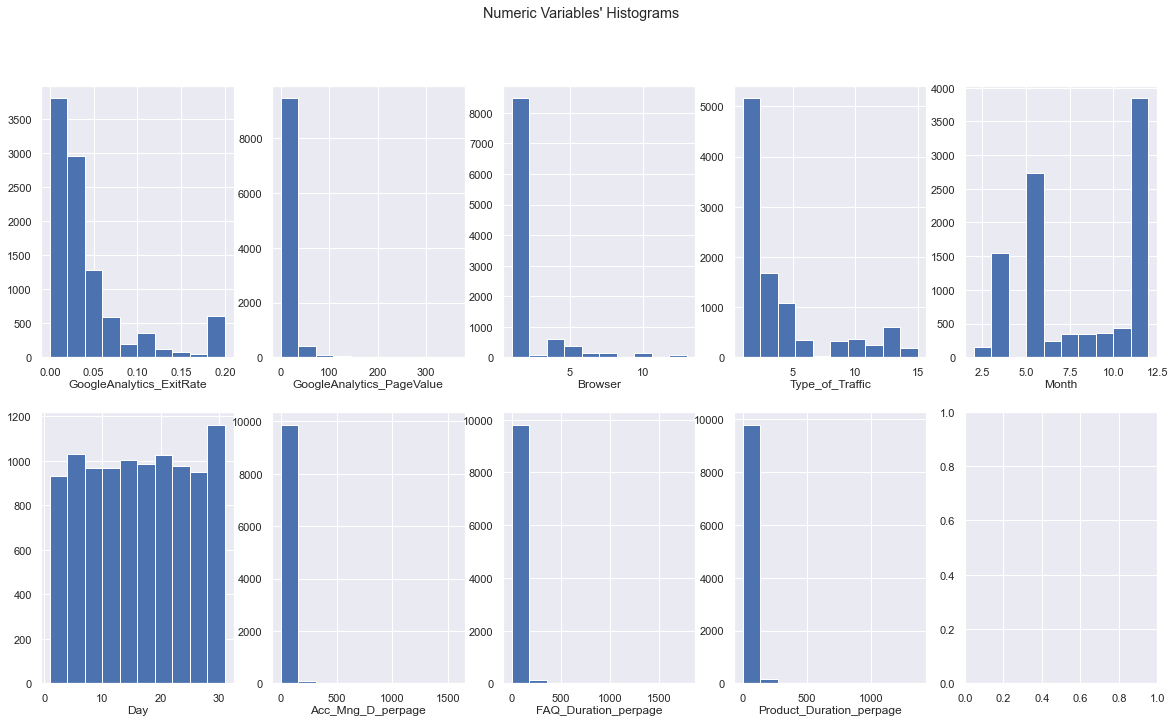

In [34]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df_[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

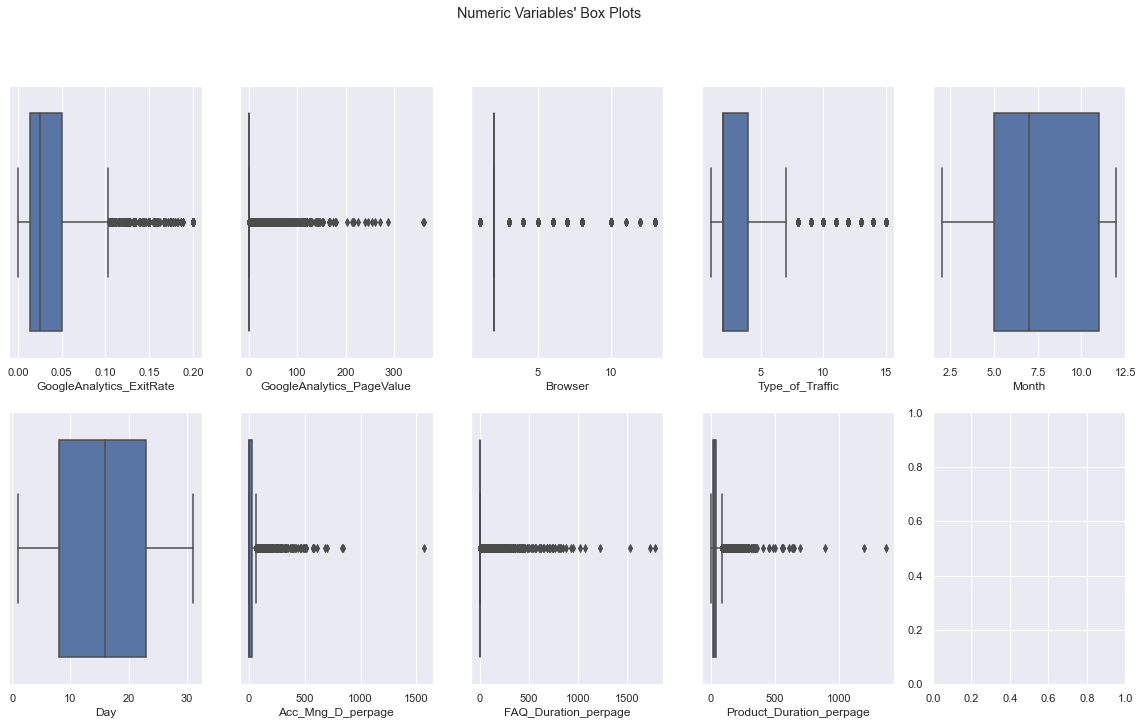

In [35]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [36]:
# # Pairwise Relationship of Numerical Variables
# sns.set()

# # Setting pairplot
# sns.pairplot(df_[metric_features], diag_kind="hist")

# # Layout
# plt.subplots_adjust(top=0.95)
# plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

# #plt.savefig(os.path.join('..', 'figures', 'pairwise_relationship_of_numerical_variables.png'), dpi=200)
# plt.show()

<AxesSubplot:>

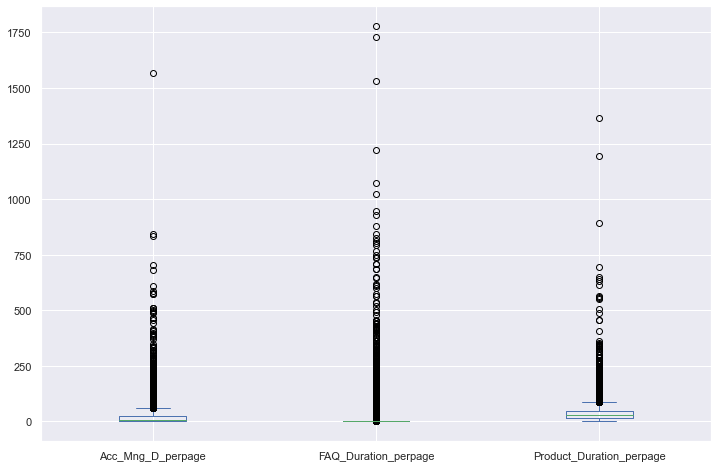

In [37]:
df_[["Acc_Mng_D_perpage","FAQ_Duration_perpage","Product_Duration_perpage"]].plot.box(figsize = (12,8))

let's remove all observation above 750

In [38]:
#removing outliers using manual way 
filters = (
    (df_['Acc_Mng_D_perpage'] < 250)
    &
    (df_['FAQ_Duration_perpage'] < 250)
    &
    (df_['Product_Duration_perpage'] < 250)
)

data_1 = df_[filters]
print('Percentage of data kept after removing outliers:', np.round(data_1.shape[0] / df_.shape[0], 4))

Percentage of data kept after removing outliers: 0.9775


<AxesSubplot:>

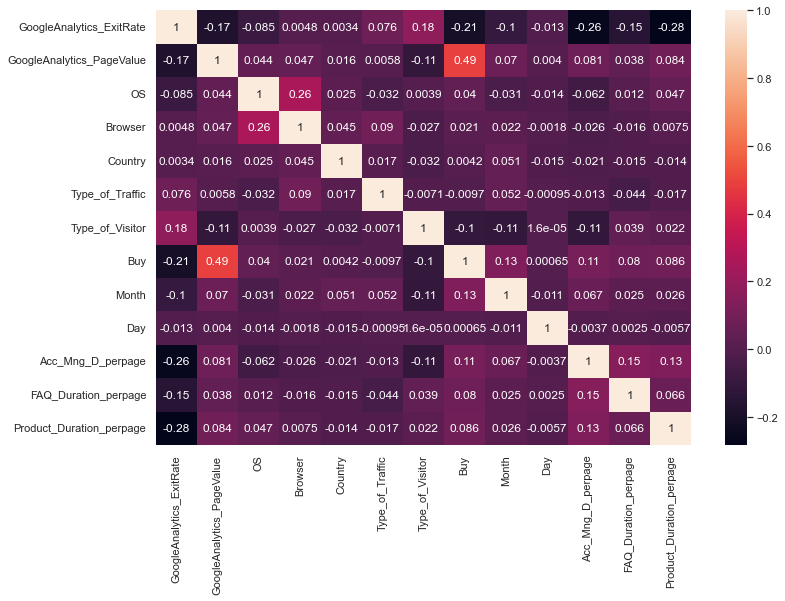

In [39]:
plt.figure(figsize = (12,8))
sns.heatmap(data_1.corr(), annot = True)

In [40]:
model = IsolationForest()
model.fit(df_)

outlier_label = model.fit_predict(df_)
outlier_pd = pd.DataFrame(outlier_label, columns=["Outlier"])
df_train = pd.concat((df_, outlier_pd), axis=1)
df_train
df_train_sem_outlier = df_train.loc[df_train.Outlier == 1]
df_train_sem_outlier = df_train_sem_outlier.drop(columns = ["Outlier"])
percentage_reduced = 1 - (len(df_train_sem_outlier)/len(df_train))
percentage_reduced

0.1227122712271227

In [41]:
df_train_sem_outlier = df_train_sem_outlier.reset_index(drop = True)
df_train_sem_outlier

,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage
0,0.0667,0.0000,3.0,2,5.0,1,2.0,0,3,21,0.000000,0.00,21.333333
1,0.0449,0.0000,6.0,2,1.0,6,2.0,0,5,20,0.000000,0.00,29.760870
2,0.0583,0.0000,6.0,4,3.0,1,2.0,0,12,4,0.000000,0.00,11.875000
3,0.0250,42.4225,6.0,2,8.0,2,2.0,1,12,22,0.000000,0.00,67.638889
4,0.0017,0.0000,6.0,2,5.0,6,2.0,0,3,4,4.333333,0.00,11.598900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.0469,0.0000,0.0,1,5.0,3,2.0,0,5,8,0.000000,0.00,28.920831
8768,0.0111,0.0000,3.0,2,0.0,14,2.0,0,5,8,53.000000,27.75,47.831522
8769,0.0519,0.0000,3.0,2,1.0,3,2.0,0,3,23,0.000000,0.00,23.851852
8770,0.0363,0.0000,6.0,2,3.0,3,2.0,0,5,16,0.000000,0.00,13.500000


<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 5. Preprocessing Data
     
</a>
    
 

</div>

[<font color='#E8800A'>4.1 - MinMax Scaling</font>](#first-bullet) <br>
 

In [42]:
df_minmax = df_.copy()

In [43]:
df_minmax

,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage
0,0.0667,0.0000,3.0,2,5.0,1,2.0,0,3,21,0.000000,0.00,21.333333
1,0.0449,0.0000,6.0,2,1.0,6,2.0,0,5,20,0.000000,0.00,29.760870
2,0.0583,0.0000,6.0,4,3.0,1,2.0,0,12,4,0.000000,0.00,11.875000
3,0.0250,42.4225,6.0,2,8.0,2,2.0,1,12,22,0.000000,0.00,67.638889
4,0.0093,12.5033,6.0,2,6.0,3,2.0,1,11,24,0.000000,193.00,44.720547
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0111,0.0000,3.0,2,0.0,14,2.0,0,5,8,53.000000,27.75,47.831522
9995,0.0111,0.0000,6.0,10,6.0,5,0.0,0,7,17,29.183333,0.00,9.200000
9996,0.0519,0.0000,3.0,2,1.0,3,2.0,0,3,23,0.000000,0.00,23.851852
9997,0.0363,0.0000,6.0,2,3.0,3,2.0,0,5,16,0.000000,0.00,13.500000


In [44]:
df_minmax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   GoogleAnalytics_ExitRate   9999 non-null   float64
 1   GoogleAnalytics_PageValue  9999 non-null   float64
 2   OS                         9999 non-null   float64
 3   Browser                    9999 non-null   int64  
 4   Country                    9999 non-null   float64
 5   Type_of_Traffic            9999 non-null   int64  
 6   Type_of_Visitor            9999 non-null   float64
 7   Buy                        9999 non-null   int64  
 8   Month                      9999 non-null   int64  
 9   Day                        9999 non-null   int64  
 10  Acc_Mng_D_perpage          9999 non-null   float64
 11  FAQ_Duration_perpage       9999 non-null   float64
 12  Product_Duration_perpage   9999 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 1015.6 KB


In [45]:
# Use MinMaxScaler to scale the metric features
minmax = MinMaxScaler()
scaled_feat_minmax = minmax.fit_transform(df_[independent_features])
scaled_feat_minmax
df_minmax = pd.DataFrame(scaled_feat_minmax, columns = independent_features)
df_minmax = pd.concat([df_minmax, df_[['Buy']]], axis = 1)
df_minmax

,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage,Buy
0,0.3335,0.000000,0.428571,0.083333,0.625,0.000000,1.0,0.1,0.666667,0.000000,0.000000,0.015640,0
1,0.2245,0.000000,0.857143,0.083333,0.125,0.357143,1.0,0.3,0.633333,0.000000,0.000000,0.021819,0
2,0.2915,0.000000,0.857143,0.250000,0.375,0.000000,1.0,1.0,0.100000,0.000000,0.000000,0.008706,0
3,0.1250,0.117266,0.857143,0.083333,1.000,0.071429,1.0,1.0,0.700000,0.000000,0.000000,0.049589,1
4,0.0465,0.034562,0.857143,0.083333,0.750,0.142857,1.0,0.9,0.766667,0.000000,0.108549,0.032786,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0555,0.000000,0.428571,0.083333,0.000,0.928571,1.0,0.3,0.233333,0.033831,0.015607,0.035067,0
9995,0.0555,0.000000,0.857143,0.750000,0.750,0.285714,0.0,0.5,0.533333,0.018628,0.000000,0.006745,0
9996,0.2595,0.000000,0.428571,0.083333,0.125,0.142857,1.0,0.1,0.733333,0.000000,0.000000,0.017487,0
9997,0.1815,0.000000,0.857143,0.083333,0.375,0.142857,1.0,0.3,0.500000,0.000000,0.000000,0.009897,0


</div>

[<font color='#E8800A'>4.2 - Scaling data with outliers (RobustScaler)</font>](#first-bullet) <br>
"If your data contains many outliers, scaling using the mean and variance of the data is likely to not work very well. In these cases, you can use RobustScaler as a drop-in replacement instead. It uses more robust estimates for the center and range of your data."

Source: https://scikit-learn.org/stable/modules/preprocessing.html

In [46]:
df_robust = df_.copy()

In [47]:
# RobustScaler
robust = RobustScaler()
scaled_feat_robust = robust.fit_transform(df_[independent_features])
df_robust = pd.DataFrame(scaled_feat_robust, columns = independent_features)
df_robust = pd.concat([df_robust, df_[['Buy']]], axis = 1)
df_robust

,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage,Buy
0,1.165266,0.0000,-1.0,0.0,0.000000,-0.5,0.0,-0.666667,0.333333,-0.207159,0.00,-0.275440,0
1,0.554622,0.0000,0.0,0.0,-1.333333,2.0,0.0,-0.333333,0.266667,-0.207159,0.00,0.030638,0
2,0.929972,0.0000,0.0,2.0,-0.666667,-0.5,0.0,0.833333,-0.800000,-0.207159,0.00,-0.618956,0
3,-0.002801,42.4225,0.0,0.0,1.000000,0.0,0.0,0.833333,0.400000,-0.207159,0.00,1.406323,1
4,-0.442577,12.5033,0.0,0.0,0.333333,0.5,0.0,0.666667,0.533333,-0.207159,193.00,0.573956,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,-0.392157,0.0000,-1.0,0.0,-1.666667,6.0,0.0,-0.333333,-0.533333,1.988722,27.75,0.686943,0
9995,-0.392157,0.0000,0.0,8.0,0.333333,1.5,-2.0,0.000000,0.066667,1.001957,0.00,-0.716109,0
9996,0.750700,0.0000,-1.0,0.0,-1.333333,0.5,0.0,-0.666667,0.466667,-0.207159,0.00,-0.183971,0
9997,0.313725,0.0000,0.0,0.0,-0.666667,0.5,0.0,-0.333333,0.000000,-0.207159,0.00,-0.559938,0


</div>

[<font color='#E8800A'>4.3 - Power Transform </font>](#first-bullet) <br>

In [48]:
# power transform
pt = PowerTransformer()
data_X = df_.drop(columns = ["Buy"])
data = pt.fit_transform(data_X)
df_power = pd.DataFrame(data, columns = list(data_X.columns))
df_power = pd.concat([df_power, df_[["Buy"]]], axis = 1)
df_power

,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage,Buy
0,1.107993,-0.532301,-0.580010,0.103599,0.296126,-1.453100,0.414258,-1.431554,0.627623,-1.001029,-0.494594,-0.298966,0
1,0.573254,-0.532301,0.768907,0.103599,-1.498295,1.044777,0.414258,-0.735787,0.525237,-1.001029,-0.494594,0.039028,0
2,0.930941,-0.532301,0.768907,1.395916,-0.695387,-1.453100,0.414258,1.232783,-1.395954,-1.001029,-0.494594,-0.808985,0
3,-0.193262,1.970805,0.768907,0.103599,2.050414,-0.385797,0.414258,1.232783,0.728772,-1.001029,-0.494594,1.045438,1
4,-1.087046,1.921809,0.768907,0.103599,0.848550,0.201458,0.414258,0.979635,0.927624,-1.001029,2.075891,0.505440,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,-0.967956,-0.532301,-0.580010,0.103599,-1.801018,1.758667,0.414258,-0.735787,-0.840507,1.268643,2.045975,0.588480,0
9995,-0.967956,-0.532301,0.768907,2.351640,0.848550,0.845646,-2.424100,-0.116950,0.209858,1.014597,-0.494594,-1.000331,0
9996,0.772955,-0.532301,-0.580010,0.103599,-1.498295,0.201458,0.414258,-1.431554,0.828752,-1.001029,-0.494594,-0.189786,0
9997,0.282454,-0.532301,0.768907,0.103599,-0.695387,0.201458,0.414258,-0.735787,0.101677,-1.001029,-0.494594,-0.706004,0


In [49]:
# I decided to use Power Transform

<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 5. Stratified K-Fold Cross Validation
     
</a>
    
</div>

 

In [50]:
df_X = df_power.iloc[:,:-1] #(data)
df_Y = df_power.iloc[:,-1] #(Y_)

In [51]:
df_Y

0       0
1       0
2       0
3       1
4       1
       ..
9994    0
9995    0
9996    0
9997    0
9998    0
Name: Buy, Length: 9999, dtype: int64

In [52]:
from sklearn.model_selection import StratifiedKFold

In [64]:
#define number of splits and which model to train
def avg_score_skf(n_splits, model, df_X, df_Y):
    # create stratifiedKFold object
    skf = StratifiedKFold(n_splits)
    lst_accu_stratified_train = []
    lst_accu_stratified_val = []
    f1score = []
     
    
    for train_index, val_index in skf.split(df_X,df_Y):
        x_train_fold, x_val_fold = df_X.iloc[train_index], df_X.iloc[val_index] 
        y_train_fold, y_val_fold = df_Y.iloc[train_index], df_Y.iloc[val_index]
        
        model_fit = model.fit(x_train_fold, y_train_fold)

        y_pred = model.predict(x_val_fold)

        value_train = model_fit.score(x_train_fold, y_train_fold)
        value_val = model_fit.score(x_val_fold,y_val_fold)
        value_f1 = f1_score(y_val_fold, y_pred)

        lst_accu_stratified_train.append(value_train)
        lst_accu_stratified_val.append(value_val)
        f1score.append(value_f1)

    return(np.mean(f1score))   #np.mean(lst_accu_stratified_train), np.mean(lst_accu_stratified_val))

<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 6. Model Selection
     
</a>
    
</div>

[<font color='#E8800A'>1 - Logistic Regression</font>](#first-bullet) <br>
[<font color='#E8800A'>2 - KNN Classifier </font>](#second-bullet) <br>
[<font color='#E8800A'>3 - Decision Tree </font>](#second-bullet) <br>
[<font color='#E8800A'>4 - Random Forest</font>](#third-bullet) <br>

In [54]:
# Now we have created 3 different training datasets 
# 1. df_minmax
# 2. df_robust
# 3. df_power

In [55]:
# # Separating independent and dependent variable
# X = df_power.drop(columns = ["Buy"])
# Y = df_power.Buy

In [56]:
# # Train-Test Split
# x_train, x_val, y_train, y_val = train_test_split(X,Y,
#                                                   test_size = 0.25,
#                                                   random_state = 42)


## Logistic Regression

In [65]:
log_model = LogisticRegression()

In [69]:
# log_model.fit(x_train, y_train)

# mean f1 score
avg_score_skf(8, log_model, df_X, df_Y)

0.6252748330799871

In [59]:
# y_pred = log_model.predict(x_val)

In [60]:
log_model.coef_

array([[-0.4459917 ,  1.43783966,  0.02788425, -0.02125164, -0.02782501,
         0.06652914, -0.29248343,  0.42772757,  0.003581  , -0.17562223,
        -0.03988712,  0.07660514]])

# KNN Classifier

In [71]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
# lets start with k = 4
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k)

In [73]:
avg_score_skf(8, neigh, df_X, df_Y)

0.5694700207218462

## Decision Tree

In [74]:
tree_entropy = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6) 
# default is gini
tree_entropy

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [75]:
avg_score_skf(10, tree_entropy, df_X, df_Y)

0.603166366637754

In [76]:
tree_gini = DecisionTreeClassifier(criterion = 'gini', max_depth = 6)

In [77]:
avg_score_skf(10, tree_gini, df_X, df_Y)

0.6054314644915201

## Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
clf = RandomForestClassifier(max_depth = 8, random_state = 0)

In [91]:
avg_score_skf(10, clf, df_X, df_Y)

0.6144526179857424

In [933]:
#we will use below commented part for test purpose later on for kaggle submission

In [934]:
df_test = pd.read_csv("test.csv")
#df_test

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## Test Part (Last Part)
    

    
</div>

In [935]:
# Also let's do some feature engineering for test dataframe before fiting it into the model.
df_test["Month"] = pd.DatetimeIndex(df_test["Date"]).month
df_test["Year"] = pd.DatetimeIndex(df_test["Date"]).year
df_test["Day"] = pd.DatetimeIndex(df_test["Date"]).day

In [936]:
df_test = df_test.drop(columns = ["Date","Year","Access_ID"])

In [ ]:
df_test["OS"] = Label_encoder.fit_transform(df_test[["OS"]])
df_test["Country"] = Label_encoder.fit_transform(df_test[["Country"]])
df_test["Type_of_Visitor"] = Label_encoder.fit_transform(df_test[["Type_of_Visitor"]])

In [ ]:
# df_test

In [ ]:
# Creating logistic regression instance
#log_model = LogisticRegression(random_state = 42)

In [ ]:
# log_model.fit(X_train,Y_train)

In [ ]:
# y_pred = log_model.predict(df_test)

In [ ]:
#y_pred

In [ ]:
#print(y_pred.tolist().count(0), y_pred.tolist().count(1))



In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators = 1000)
# abc = clf.fit(x_train_d, y_train_d)
# y_pred = clf.predict(x_val_d)
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# f1_score(y_val_d, y_pred)

In [ ]:
# print('F1 Score:' ,f1_score(y_val_d, y_pred))
# print('Mean Accuracy:' ,abc.score(x_val, y_val))